In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [3]:
data = pd.read_csv('data_format2/train_format2.csv')
test_data = pd.read_csv('data_format2/test_format2.csv')

In [4]:
def split_data(data):
    user_habit = data[data['label'] == -1]
    real_data = data[data['label'] != -1]
    return real_data, user_habit

In [16]:
# 分割用户在这家店铺的记录和在别家店铺的记录
train_data, train_user_habit = split_data(data)

In [179]:
train_data.head()

,user_id,age_range,gender,merchant_id,label,activity_log
6,34176,6.0,0.0,3906,0,757713:821:6268:1110:0#757713:821:6268:1110:0#...
30,34176,6.0,0.0,121,0,800752:1028:2337:1110:0#800752:1028:2337:1110:...
40,34176,6.0,0.0,4356,1,709909:1208:2276:1110:0#709909:1208:2276:1110:...
63,34176,6.0,0.0,2217,0,399879:656:3012:1111:2#399879:656:3012:1111:0
117,230784,0.0,0.0,4818,0,155695:2:7606:1111:2#155695:2:7606:1111:0#1556...


In [180]:
train_user_habit.head()

,user_id,age_range,gender,merchant_id,label,activity_log
0,34176,6.0,0.0,944,-1,408895:1505:7370:1107:0
1,34176,6.0,0.0,412,-1,17235:1604:4396:0818:0#954723:1604:4396:0818:0...
2,34176,6.0,0.0,1945,-1,231901:662:2758:0818:0#231901:662:2758:0818:0#...
3,34176,6.0,0.0,4752,-1,174142:821:6938:1027:0
4,34176,6.0,0.0,643,-1,716371:1505:968:1024:3


In [7]:
# 异常值检测
print('len train data:', len(train_data))
print('non in train log:', sum(train_data['activity_log'].isnull()))
print('non in age_range:', sum(train_data['age_range'].isnull()))
print('non in gender:', sum(train_data['gender'].isnull()))
print('non in label:', sum(train_data['label'].isnull()))

len train data: 260864
non in train log: 53
non in age_range: 1253
non in gender: 3711
non in label: 0


## 用户基础信息分析

### 是否重复购买和性别与年龄的关系

In [6]:
def get_new_gender(data):
    data.loc[:, 'new_gender'] = data['gender'].fillna(2)
    
def get_new_age_range(data):
    data.loc[:, 'new_age_range'] = data['age_range'].fillna(0)

In [21]:
get_new_age_range(train_data)
get_new_gender(train_data)

/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
age_data = pd.crosstab(train_data['new_age_range'], train_data['label'], margins=True)
age_data['repeat_percent'] = age_data[1] / age_data['All']
age_data

label,0,1,All,repeat_percent
new_age_range,,,,
0.0,53740,3322,57062,0.058217
1.0,13,0,13,0.000000
2.0,29495,1531,31026,0.049346
3.0,65289,4080,69369,0.058816
4.0,47791,3444,51235,0.067220
5.0,23825,1793,25618,0.069990
6.0,20218,1483,21701,0.068338
7.0,3871,249,4120,0.060437
8.0,670,50,720,0.069444


260864条新用户记录中57062条不知道年龄。

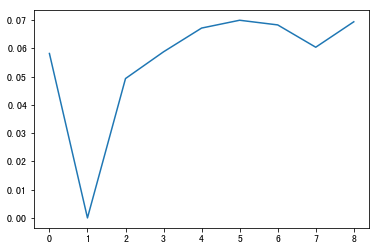

In [23]:
plt.plot(age_data.iloc[0:9, 3])
plt.show()

0代表未知年龄，这部分的重复购买的概率差不多在平均水平，也算是一种公平的估计。

In [24]:
gender_data = pd.crosstab(train_data['new_gender'], train_data['label'], margins=True)
gender_data['repeat_percent'] = gender_data[1] / gender_data['All']
gender_data

label,0,1,All,repeat_percent
new_gender,,,,
0.0,165027,11387,176414,0.064547
1.0,69787,3969,73756,0.053813
2.0,10098,596,10694,0.055732
All,244912,15952,260864,0.061151


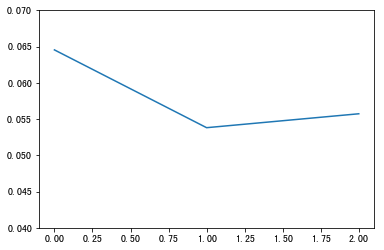

In [25]:
plt.plot(gender_data.iloc[0:3, 3])
plt.ylim((0.04,0.07))
plt.show()

## 用户习惯分析

### 用户常购买的店铺数和店铺的回头客数

In [158]:
# 用户经常重复购买的店家数目
buyer_repeat_sellers = train_user_habit[['user_id','label']].groupby('user_id', as_index=False).count()
buyer_repeat_sellers.columns = ['user_id', 'buyer_repeat_sellers']
train_new_data = pd.merge(train_data, buyer_repeat_sellers, on='user_id', how='left')
train_new_data['buyer_repeat_sellers'].fillna(0, inplace=True)

# 卖家的老顾客数目
seller_repeat_buyers = train_user_habit[['merchant_id','label']].groupby('merchant_id', as_index=False).count()
seller_repeat_buyers.columns = ['merchant_id', 'seller_repeat_buyers']
train_new_data = pd.merge(train_new_data, seller_repeat_buyers, on='merchant_id', how='left')
train_new_data['seller_repeat_buyers'].fillna(0, inplace=True)

train_new_data.head()

,user_id,age_range,gender,merchant_id,label,activity_log,new_age_range,new_gender,repeat_cpi,action_cpi,earliest_action,item_num_cpi,bought_same_cat_cpi,buyer_repeat_sellers,seller_repeat_buyers
0,34176,6.0,0.0,3906,0,757713:821:6268:1110:0#757713:821:6268:1110:0#...,6.0,0.0,87,2,1,20,0,105.0,2861
1,34176,6.0,0.0,121,0,800752:1028:2337:1110:0#800752:1028:2337:1110:...,6.0,0.0,89,1,0,1,0,105.0,4530
2,34176,6.0,0.0,4356,1,709909:1208:2276:1110:0#709909:1208:2276:1110:...,6.0,0.0,84,6,0,2,0,105.0,1088
3,34176,6.0,0.0,2217,0,399879:656:3012:1111:2#399879:656:3012:1111:0,6.0,0.0,92,1,0,1,0,105.0,7268
4,230784,0.0,0.0,4818,0,155695:2:7606:1111:2#155695:2:7606:1111:0#1556...,0.0,0.0,45,1,0,1,0,19.0,3102


In [159]:
# 乘10因为买家数字和卖家数字不在一个数量级
train_new_data.loc[:, 'repeat'] = train_new_data['seller_repeat_buyers'] + train_new_data['buyer_repeat_sellers'] * 100


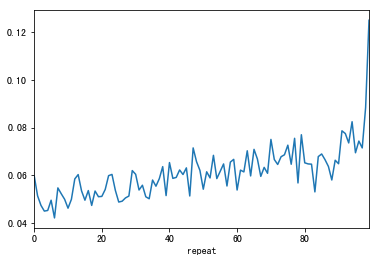

label,0,1,All,percent
repeat,,,,
0,2455,156,2611,0.059747
1,2475,134,2609,0.051361
2,2494,124,2618,0.047364
3,2485,117,2602,0.044965
4,2512,119,2631,0.045230
5,2476,129,2605,0.049520
6,2480,109,2589,0.042101
7,2472,143,2615,0.054685
8,2486,137,2623,0.052230


In [160]:
repeat_bins_data = pd.qcut(train_new_data['repeat'], 100, duplicates='drop', labels=False)
repeat_data = pd.crosstab(repeat_bins_data, train_new_data['label'], margins=True)
repeat_data['percent'] = repeat_data[1] / repeat_data['All']
repeat_data.iloc[:-1, 3].plot()
plt.show()
repeat_data

In [161]:
train_data.loc[:,'repeat_cpi'] = repeat_bins_data.values
print(sum(train_data['repeat_cpi'].isnull()))
train_data.head()

/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0


,user_id,age_range,gender,merchant_id,label,activity_log,new_age_range,new_gender,repeat_cpi,action_cpi,earliest_action,item_num_cpi,bought_same_cat_cpi
6,34176,6.0,0.0,3906,0,757713:821:6268:1110:0#757713:821:6268:1110:0#...,6.0,0.0,87,2,1,20,0
30,34176,6.0,0.0,121,0,800752:1028:2337:1110:0#800752:1028:2337:1110:...,6.0,0.0,89,1,0,1,0
40,34176,6.0,0.0,4356,1,709909:1208:2276:1110:0#709909:1208:2276:1110:...,6.0,0.0,84,6,0,2,0
63,34176,6.0,0.0,2217,0,399879:656:3012:1111:2#399879:656:3012:1111:0,6.0,0.0,92,1,0,1,0
117,230784,0.0,0.0,4818,0,155695:2:7606:1111:2#155695:2:7606:1111:0#1556...,0.0,0.0,45,1,0,1,0


In [7]:
def get_repeat_cpi(data, habit_data):
    buyer_repeat_sellers = habit_data[['user_id','label']].groupby('user_id', as_index=False).count()
    buyer_repeat_sellers.columns = ['user_id', 'buyer_repeat_sellers']
    new_data = pd.merge(data, buyer_repeat_sellers, on='user_id', how='left')
    new_data['buyer_repeat_sellers'].fillna(0, inplace=True)

    # 卖家的老顾客数目
    seller_repeat_buyers = habit_data[['merchant_id','label']].groupby('merchant_id', as_index=False).count()
    seller_repeat_buyers.columns = ['merchant_id', 'seller_repeat_buyers']
    new_data = pd.merge(new_data, seller_repeat_buyers, on='merchant_id', how='left')
    new_data['seller_repeat_buyers'].fillna(0, inplace=True)
    
    repeat = new_data['seller_repeat_buyers'] + new_data['buyer_repeat_sellers'] * 100
    repeat_bins_data = pd.qcut(repeat, 100, duplicates='drop', labels=False)
    data.loc[:,'repeat_cpi'] = repeat_bins_data.values

## 买家双十一期间的行为分析

### 买家购买、点击、喜欢的次数

In [8]:
def log_times(logs, log_type):
    count = 0
    if logs:
        logs = str(logs) + '#'
        ss = str(log_type) + '#'
        count = logs.count(ss)
    return count

In [135]:
buy_times = train_data['activity_log'].apply(log_times, log_type=2)
click_times = train_data['activity_log'].apply(log_times, log_type=0)
like_times = train_data['activity_log'].apply(log_times, log_type=3)
cart_times = train_data['activity_log'].apply(log_times, log_type=1)

new_buy_times = buy_times + click_times * 0.02 + like_times * 0.2 + cart_times * 0.5
buy_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 25, 100]
buy_bins_data = pd.cut(new_buy_times, bins=buy_bins, labels=range(0,13), include_lowest=True)

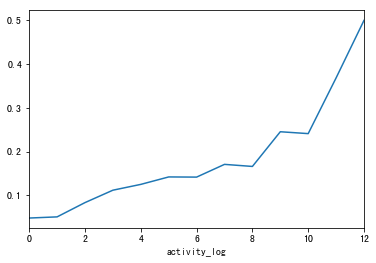

label,0,1,All,percent
activity_log,,,,
0,21097,1062,22159,0.047926
1,172765,9207,181972,0.050596
2,32133,2918,35051,0.083250
3,9655,1213,10868,0.111612
4,4519,645,5164,0.124903
5,2122,351,2473,0.141933
6,1122,185,1307,0.141546
7,622,128,750,0.170667
8,377,75,452,0.165929


In [136]:
ct = pd.crosstab(buy_bins_data, train_data['label'], margins=True)
ct['percent'] = ct[1] / ct['All']
ct.iloc[0:13, 3].plot()
plt.show()
ct

In [40]:
train_data.loc[:, 'action_cpi'] = buy_bins_data

/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
train_data.head()

,user_id,age_range,gender,merchant_id,label,activity_log,earliest_action,new_age_range,new_gender,repeat_cpi,action_cpi
6,34176,6.0,0.0,3906,0,757713:821:6268:1110:0#757713:821:6268:1110:0#...,1,6.0,0.0,88,2
30,34176,6.0,0.0,121,0,800752:1028:2337:1110:0#800752:1028:2337:1110:...,0,6.0,0.0,90,1
40,34176,6.0,0.0,4356,1,709909:1208:2276:1110:0#709909:1208:2276:1110:...,0,6.0,0.0,84,6
63,34176,6.0,0.0,2217,0,399879:656:3012:1111:2#399879:656:3012:1111:0,0,6.0,0.0,92,1
117,230784,0.0,0.0,4818,0,155695:2:7606:1111:2#155695:2:7606:1111:0#1556...,0,0.0,0.0,46,1


In [9]:
def get_action_cpi(data):
    buy_times = data['activity_log'].apply(log_times, log_type=2)
    click_times = data['activity_log'].apply(log_times, log_type=0)
    like_times = data['activity_log'].apply(log_times, log_type=3)
    cart_times = data['activity_log'].apply(log_times, log_type=1)
    
    new_buy_times = buy_times + click_times * 0.02 + like_times * 0.2 + cart_times * 0.5
    buy_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 25, 100]
    buy_bins_data = pd.cut(new_buy_times, bins=buy_bins, labels=range(0,13), include_lowest=True)
    data.loc[:, 'action_cpi'] = buy_bins_data

### 用户在店铺第一次操作离双十一有多久

In [17]:
train_habit_user_group = train_user_habit[['user_id', 'activity_log']].groupby('user_id')

In [10]:
def get_group_habit(habit_data):
    habit_group = habit_data[['user_id', 'activity_log']].groupby('user_id')
    return habit_group

In [11]:
def log_first_time(logs):
    pattern = re.compile(r'(\d{1,7}):(\d{1,4}):(\d{1,4}):(\d{4}):([0-3]{1})#?')
    match = pattern.findall(str(logs))
    item_num, earliest_action, cats = 0, 0, []
    if match:
        match = np.array(match)
        item_num = len(np.unique(match[:, 0]))
        cats = np.unique(match[match[:, 4] == '2'][:, 1])
        earliest_action = 11 - (int(np.sort(np.unique(match[:, 3]))[0]) // 100)
    return item_num, earliest_action, cats

In [18]:
def bought_times(item, group_habit_data=train_habit_user_group):
    right_cats = 0
    if item['user_id'] in group_habit_data.groups:
        habit = group_habit_data.get_group(item['user_id'])['activity_log']
        habit = habit.apply(str)
        all_activities = '#'.join(habit)
        cats = item['1111_cats']
        pattern = re.compile(r'(\d{1,7}):(\d{1,4}):(\d{1,4}):(\d{4}):([0-3]{1})#?')
        match = pattern.findall(str(all_activities))
        if match:
            match = np.array(match)
            match_cats = match[match[:, 4] == '2'][:, 1]
            right_cats = sum([c in cats for c in match_cats])
    return right_cats

In [19]:
def get_others(data, habit_data):
    group_habit_data = get_group_habit(habit_data)
    log_analysis = data['activity_log'].apply(log_first_time)
    item_num, data.loc[:, 'earliest_action'], bought_cats = zip(*log_analysis)
    
    item_num_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 40, 60, 100, 1000]
    item_num_bins_data = pd.cut(item_num, bins=item_num_bins, labels=range(0, 26), include_lowest=True)
    data.loc[:, 'item_num_cpi'] = item_num_bins_data
    data.loc[:, 'item_num_cpi'] = item_num
    
    data.loc[:, '1111_cats'] = bought_cats
    bought_same_cat = data[['user_id', '1111_cats']].apply(bought_times, group_habit_data=group_habit_data, axis=1)
    del data['1111_cats']
    same_cat_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 300]
    same_cat_bins_data = pd.cut(bought_same_cat, bins=same_cat_bins, labels=range(0, 11), include_lowest=True)
    data.loc[:, 'bought_same_cat_cpi'] = same_cat_bins_data


In [11]:
log_analysis = train_data['activity_log'].apply(log_first_time)
item_num, train_data.loc[:, 'earliest_action'], bought_cats = zip(*log_analysis)

/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


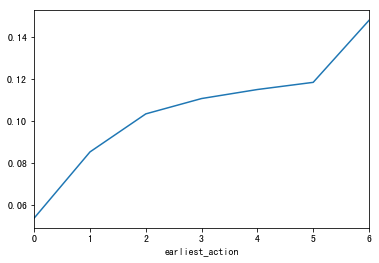

label,0,1,All,repeat_percent
earliest_action,,,,
0,208943,11867,220810,0.053743
1,16989,1584,18573,0.085285
2,5444,628,6072,0.103426
3,3477,433,3910,0.110742
4,2923,380,3303,0.115047
5,4569,614,5183,0.118464
6,2567,446,3013,0.148025
All,244912,15952,260864,0.061151


In [19]:
earliest_action_data = pd.crosstab(train_data['earliest_action'], train_data['label'], margins=True)
earliest_action_data['repeat_percent'] = earliest_action_data[1] / earliest_action_data['All']
earliest_action_data.iloc[0:7, 3].plot()
plt.show()
earliest_action_data

越早关注店铺的买家越可能重复购买

### 用户操作过的店铺项目数

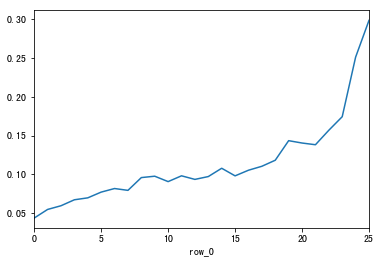

label,0,1,All,repeat_percent
row_0,,,,
0,107567,4894,112461,0.043517
1,40073,2315,42388,0.054615
2,23501,1484,24985,0.059396
3,15405,1108,16513,0.067099
4,11083,829,11912,0.069594
5,7983,666,8649,0.077003
6,6143,546,6689,0.081627
7,4902,422,5324,0.079264
8,3815,404,4219,0.095757


In [51]:
item_num_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 40, 60, 100, 1000]
item_num_bins_data = pd.cut(item_num, bins=item_num_bins, labels=range(0, 26), include_lowest=True)
item_num_data = pd.crosstab(bins_data, train_data['label'], margins=True)
item_num_data['repeat_percent'] = item_num_data[1] / item_num_data['All']
item_num_data.iloc[:-1, 3].plot()
plt.show()
item_num_data

In [52]:
train_data.loc[:, 'item_num_cpi'] = item_num_bins_data
train_data.head()

/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,user_id,age_range,gender,merchant_id,label,activity_log,earliest_action,new_age_range,new_gender,repeat_cpi,action_cpi,item_num_cpi
6,34176,6.0,0.0,3906,0,757713:821:6268:1110:0#757713:821:6268:1110:0#...,1,6.0,0.0,88,2,19
30,34176,6.0,0.0,121,0,800752:1028:2337:1110:0#800752:1028:2337:1110:...,0,6.0,0.0,90,1,0
40,34176,6.0,0.0,4356,1,709909:1208:2276:1110:0#709909:1208:2276:1110:...,0,6.0,0.0,84,6,1
63,34176,6.0,0.0,2217,0,399879:656:3012:1111:2#399879:656:3012:1111:0,0,6.0,0.0,92,1,0
117,230784,0.0,0.0,4818,0,155695:2:7606:1111:2#155695:2:7606:1111:0#1556...,0,0.0,0.0,46,1,0


### 过去购买相同类商品数

In [53]:
train_data.loc[:, '1111_cats'] = bought_cats
bought_same_cat = train_data[['user_id', '1111_cats']].apply(bought_times, axis=1)
del train_data['1111_cats']

/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


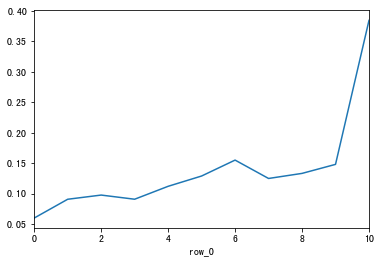

label,0,1,All,repeat_percent
row_0,,,,
0,237534,15165,252699,0.060012
1,4543,454,4997,0.090855
2,1477,160,1637,0.097740
3,630,63,693,0.090909
4,293,37,330,0.112121
5,162,24,186,0.129032
6,98,18,116,0.155172
7,56,8,64,0.125000
8,65,10,75,0.133333


In [61]:
same_cat_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 300]
same_cat_bins_data = pd.cut(bought_same_cat, bins=same_cat_bins, labels=range(0, 11), include_lowest=True)
same_cat_data = pd.crosstab(same_cat_bins_data, train_data['label'], margins=True)
same_cat_data['repeat_percent'] = same_cat_data[1] / same_cat_data['All']
same_cat_data.iloc[:-1, 3].plot()
plt.show()
same_cat_data

In [55]:
train_data.loc[:, 'bought_same_cat_cpi'] = same_cat_bins_data
train_data.head()

/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,user_id,age_range,gender,merchant_id,label,activity_log,earliest_action,new_age_range,new_gender,repeat_cpi,action_cpi,item_num_cpi,bought_same_cat_cpi
6,34176,6.0,0.0,3906,0,757713:821:6268:1110:0#757713:821:6268:1110:0#...,1,6.0,0.0,88,2,19,0
30,34176,6.0,0.0,121,0,800752:1028:2337:1110:0#800752:1028:2337:1110:...,0,6.0,0.0,90,1,0,0
40,34176,6.0,0.0,4356,1,709909:1208:2276:1110:0#709909:1208:2276:1110:...,0,6.0,0.0,84,6,1,0
63,34176,6.0,0.0,2217,0,399879:656:3012:1111:2#399879:656:3012:1111:0,0,6.0,0.0,92,1,0,0
117,230784,0.0,0.0,4818,0,155695:2:7606:1111:2#155695:2:7606:1111:0#1556...,0,0.0,0.0,46,1,0,0


### 预测

In [20]:
train_data, train_habit = split_data(data)
get_new_age_range(train_data)
get_new_gender(train_data)
get_repeat_cpi(train_data, train_habit)
get_action_cpi(train_data)
get_others(train_data, train_habit)
feature = train_data[['new_age_range', 'new_gender', 'repeat_cpi', 'action_cpi', 'earliest_action', 'item_num_cpi', 'bought_same_cat_cpi']].values
print(feature.shape)
out = train_data['label']

/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(260864, 7)


In [21]:
feature_train, feature_test, out_train, out_test = train_test_split(feature, out, test_size=0.2)
clf = GaussianNB()
# clf = RandomForestClassifier(min_samples_split=30, random_state=0)
clf.fit(feature, out)

GaussianNB(priors=None)

In [114]:
pre = clf.predict(feature_test)
score = accuracy_score(pre, out_test)
print(score)
prob = clf.predict_proba(feature_test)
prob[:, 1][:10]

0.938473923294


array([ 0.030519  ,  0.01626407,  0.07081905,  0.20228662,  0.01621622,
        0.        ,  0.        ,  0.        ,  0.00454545,  0.0444351 ])

## 测试

In [22]:
totest_data, test_habit = split_data(test_data)
test_habit.head()
get_new_age_range(totest_data)
get_new_gender(totest_data)
get_repeat_cpi(totest_data, test_habit)
get_action_cpi(totest_data)
get_others(totest_data, test_habit)


/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
test_feature = totest_data[['new_age_range', 'new_gender', 'repeat_cpi', 'action_cpi', 'earliest_action', 'item_num_cpi', 'bought_same_cat_cpi']]
prob = clf.predict_proba(test_feature)
submission = totest_data[['user_id', 'merchant_id']]
submission.loc[:, 'prob'] = prob[:, 1]
submission.to_csv('prediction.csv', index=False)

/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/cyw/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
